<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson6_MD_simulation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade asap3
!pip install ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.3 MB/s eta 0:00:00
  Created wheel for asap3: filename=asap3-3.13.5-cp310-cp310-linux_x86_64.whl size=5290633 sha256=8808d543c9ef47642d68a0ab157e968ba7c8acc8e66c6e0adbc2cba8324fd77b
  Stored in directory: /root/.cache/pip/wheels/46/ea/c9/a4842193d4c8b95860e8e90e490540e2a15f440af955ed62fc
Successfully built asap3


In [2]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (1,380 kB/s)
debconf: unable to initialize frontend: Dialo

In [2]:
import os
import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=1.0, rotation='15z,-70x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))


Atoms(symbols='Cu256', pbc=True, cell=[14.44, 14.44, 14.44])


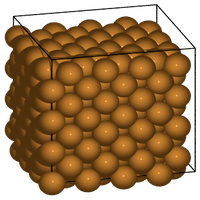

In [3]:
import os
from asap3 import EMT
import ase
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
from time import perf_counter

calculator = EMT()

# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 4
atoms_in.pbc = True
print(atoms_in)
visual(atoms_in)

In [ ]:
import numpy as np
from ase import units
from ase.md.npt import NPT
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md import MDLogger
import matplotlib.pyplot as plt
from time import perf_counter

def setup_atoms(atoms_in, calculator, temperature):
    atoms = atoms_in.copy()
    atoms.calc = calculator
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature, force_temp=True)
    Stationary(atoms)
    return atoms

def calculate_msd(positions, reference_positions):
    """Compute MSD for all atoms at each time step."""
    displacements = positions - reference_positions
    squared_displacements = np.sum(displacements**2, axis=2)  # sum over x, y, z
    msd = np.mean(squared_displacements, axis=1)  # mean over all atoms
    return msd

def print_dyn(dyn, atoms, start_time):
    """Print dynamics information: step, total energy, temperature, stress, and elapsed time."""
    imd = dyn.get_number_of_steps()
    etot = atoms.get_total_energy()
    temp_K = atoms.get_temperature()
    stress = atoms.get_stress(include_ideal_gas=True) / units.GPa
    stress_ave = (stress[0] + stress[1] + stress[2]) / 3.0
    elapsed_time = perf_counter() - start_time
    print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}   {elapsed_time:.3f}")

def run_md(atoms, time_step, temperature, sigma, ttime, pfactor, num_md_steps, num_interval, output_filename,element):
    positions = []  # To store atom positions at each interval
    log_filename = output_filename + ".log"
    traj_filename = output_filename + ".traj"
    dyn = NPT(atoms,
              time_step * units.fs,
              temperature_K=temperature,
              externalstress=sigma * units.bar,
              ttime=ttime * units.fs,
              pfactor=pfactor * units.GPa * (units.fs**2),
              logfile=log_filename,
              trajectory=traj_filename,
              loginterval=num_interval
              )

    # Attach logging and store positions
    global start_time
    start_time = perf_counter()
    atoms_positions=[atom.position for atom in atoms if atom.symbol==element]
    dyn.attach(lambda: positions.append(atoms_positions), interval=num_interval)
    dyn.attach(lambda: print_dyn(dyn, atoms, start_time), interval=num_interval)

    dyn.run(num_md_steps)

    return np.array(positions)

def initialize_and_run_md(atoms_in, calculator, num_simulations=3,element='Cu'):
    time_step = 1.0  # fsec
    num_md_steps = 1000  # 10ps, increase for more equilibration
    num_interval = 100
    sigma = 1.0  # External pressure in bar
    ttime = 20.0  # Time constant in fs
    pfactor = 2e6  # Barostat parameter in GPa*fs^2
    temperature = 300  # Room temperature in K

    print("Running", num_simulations, "MD simulations...")

    all_msds = []
    num_msd_points = (num_md_steps // num_interval)   # Number of MSD points to calculate
    time_steps = np.linspace(0, time_step * num_md_steps, num_msd_points)  # Time array with correct length

    # Run multiple MD simulations
    for i in range(num_simulations):
        output_filename = f"./{temperature}K_sim_{i+1}"
        atoms = setup_atoms(atoms_in, calculator, temperature)
        positions = run_md(atoms, time_step, temperature, sigma, ttime, pfactor, num_md_steps, num_interval, output_filename,element)

        # Calculate MSD for this simulation
        msd = calculate_msd(positions, positions[0])  # reference to initial positions
        all_msds.append(msd)

    # Convert to numpy array for easier manipulation
    all_msds = np.array(all_msds)

    # Compute mean and standard deviation of MSD
    mean_msd = np.mean(all_msds, axis=0)
    std_msd = np.std(all_msds, axis=0)

    # Plot the result
    plt.figure()
    plt.plot(time_steps, mean_msd, label='Mean MSD')
    plt.fill_between(time_steps, mean_msd - std_msd, mean_msd + std_msd, alpha=0.3, label='Uncertainty (1 std)')
    plt.xlabel('Time (fs)')
    plt.ylabel('MSD (Å²)')
    plt.title('Mean Square Displacement with Uncertainty')
    plt.legend()
    plt.show()

# Example usage
initialize_and_run_md(atoms_in, calculator, num_simulations=3,element='Cu')


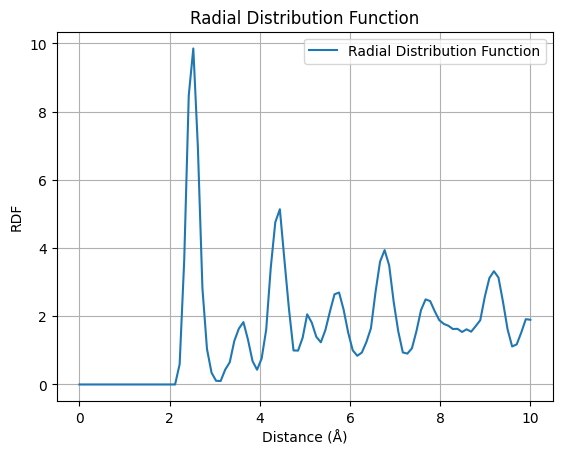

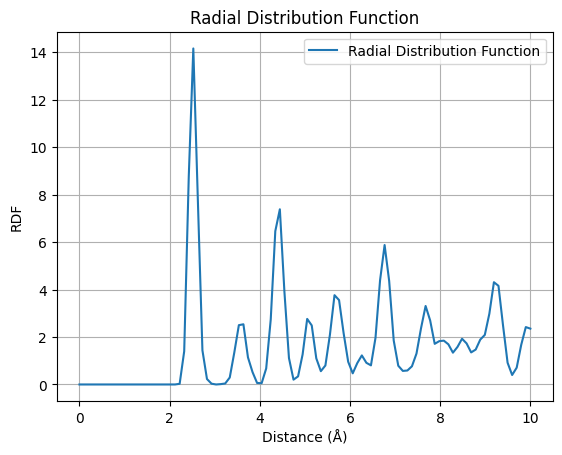

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from ase.neighborlist import NeighborList
from ase.io import Trajectory

def radial_distribution_function(atoms, r_max, bin_size, plot=True):
    """
    Calculate and plot the radial distribution function (RDF) of a system of atoms.

    Parameters:
    atoms: ASE Atoms object
        The atomic system for which to calculate the RDF.
    r_max: float
        The maximum radius to consider for the RDF (in angstroms).
    bin_size: float
        The size of the distance bins (in angstroms).
    """

    # Get the number of atoms
    num_atoms = len(atoms)

    # Calculate the number density of the system
    volume = atoms.get_volume()  # System volume in Angstrom^3
    density = num_atoms / volume  # Number density in atoms/Angstrom^3

    # Create an array of bins for the distances
    num_bins = int(r_max / bin_size)
    rdf = np.zeros(num_bins)
    r = np.linspace(0, r_max, num_bins)

    # Neighbor list to find close atoms
    cutoffs = [r_max / 2.0] * num_atoms
    neighbor_list = NeighborList(cutoffs=cutoffs, self_interaction=False, bothways=True)
    neighbor_list.update(atoms)

    # Loop over all atoms and calculate distances
    positions = atoms.get_positions()
    for i in range(num_atoms):
        indices, offsets = neighbor_list.get_neighbors(i)
        for j, offset in zip(indices, offsets):
            # Calculate distance manually
            delta_pos = positions[i] - (positions[j] + np.dot(offset, atoms.get_cell()))
            distance_ij = np.linalg.norm(delta_pos)
            if distance_ij < r_max:
                bin_index = int(distance_ij / bin_size)
                rdf[bin_index] += 2  # Counting both atoms in the pair

    # Normalize the RDF
    for i in range(num_bins):
        shell_volume = 4.0 / 3.0 * np.pi * ((r[i] + bin_size)**3 - r[i]**3)
        rdf[i] /= num_atoms * density * shell_volume

    # Plot the RDF if requested
    if plot:
        plt.figure()
        plt.plot(r, rdf, label='Radial Distribution Function')
        plt.xlabel('Distance (Å)')
        plt.ylabel('RDF')
        plt.title('Radial Distribution Function')
        plt.grid(True)
        plt.legend()
        plt.show()

    return r, rdf

r_max = 10.0  # Maximum distance (in angstroms)
bin_size = 0.1  # Bin size (in angstroms)


traj=Trajectory('./300K_sim_1.traj')
r, rdf = radial_distribution_function(traj[0], r_max, bin_size)
r, rdf = radial_distribution_function(traj[-1], r_max, bin_size)


# Displacement of Pt atoms on Au

Cell([[17.309974003446687, 0.0, 0.0], [8.654987001723343, 14.99087722583305, 0.0], [0.0, 0.0, 27.066767294881018]])


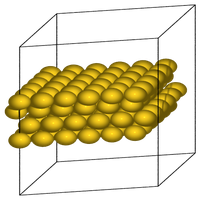

In [27]:
from ase.build import fcc111
slab = fcc111('Au', size=(6,6,4), vacuum=10.0)
print(slab.cell)
visual(slab)

Atoms(symbols='Au144Pt10', pbc=[True, True, False], cell=[[17.309974003446687, 0.0, 0.0], [8.654987001723343, 14.99087722583305, 0.0], [0.0, 0.0, 27.066767294881018]], tags=...)
New cell dimensions:  Cell([[17.309974003446687, 0.0, 0.0], [8.654987001723343, 14.99087722583305, 0.0], [0.0, 0.0, 27.066767294881018]])


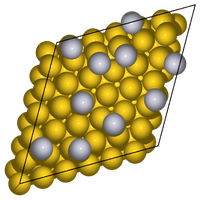

In [31]:
import numpy as np
from ase.build import fcc111
from ase import Atoms
from scipy.spatial.distance import pdist

# Step 1: Create Au slab
slab = fcc111('Au', size=(6, 6, 4), vacuum=10.0)

# Step 2: Define the random placement of Pt atoms using fractional coordinates
num_pt_atoms = 10
tolerance = 3.0  # Minimum distance between Pt atoms in Angstroms
z_offset = 2.0  # Distance above the top layer of Au in Angstroms
max_attempts = 1000  # Maximum number of attempts to place all Pt atoms

# Get the Z position just above the slab
z_position = max(slab.positions[:, 2]) + z_offset  # Z position above the slab

# List to store positions of Pt atoms in Cartesian space
pt_positions_cartesian = []

# Function to check if newly added Pt atom satisfies distance constraint
def is_valid_position(new_position, existing_positions, tol):
    if not existing_positions:
        return True
    all_positions = np.array(existing_positions + [new_position])
    distances = pdist(all_positions[:, :2])  # Only check distances in the X-Y plane
    return np.all(distances >= tol)

# Randomly place Pt atoms with distance tolerance using fractional coordinates
attempts = 0
while len(pt_positions_cartesian) < num_pt_atoms and attempts < max_attempts:
    # Generate random fractional coordinates between 0 and 1
    frac_x = np.random.uniform(0, 1)
    frac_y = np.random.uniform(0, 1)

    # Convert fractional coordinates to Cartesian using the slab cell
    cartesian_position = frac_x * slab.cell[0] + frac_y * slab.cell[1] + [0, 0, z_position]

    # Check if the position satisfies the distance tolerance
    if is_valid_position(cartesian_position, pt_positions_cartesian, tolerance):
        pt_positions_cartesian.append(cartesian_position)

    attempts += 1

# Check if placement was successful
if len(pt_positions_cartesian) != num_pt_atoms:
    raise ValueError(f"Failed to place {num_pt_atoms} Pt atoms with a tolerance of {tolerance} Å after {attempts} attempts.")

# Step 3: Create Pt atoms and add them to the slab
pt_atoms = Atoms('Pt10', positions=pt_positions_cartesian)
combined_slab = slab + pt_atoms

# Step 4: Print out the combined system
print(combined_slab)
print("New cell dimensions: ", combined_slab.cell)

visual(combined_slab, rotation='15z,-0x')


Lets make a video

In [ ]:
!pip install Pillow

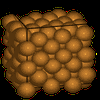

In [ ]:
import os
import shutil
import glob
import contextlib
from PIL import Image
from ase.io import write
from IPython.display import display, Image as IPImage

def visual4gif(structure, file_name, max_size=(100, 100), stretch_y=1.0, rotation='15z,-70x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)
    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)

    # Save the image with the enumerated file name
    img.save(os.path.join(png_save_path, file_name))

    # Clean up temporary files
    files = ['./temp.ini', './temp.pov', './temp.png']
    for file in files:
        if os.path.isfile(file):
            os.remove(file)

def png_to_gif(png_dir, gif_path, duration=200):
    # Find all PNG files in the directory
    png_files = sorted(glob.glob(os.path.join(png_dir, "frame*")))
    if not png_files:
        raise ValueError(f"No PNG files found in the directory: {png_dir}")
    with contextlib.ExitStack() as stack:
        imgs = [stack.enter_context(Image.open(png)) for png in png_files]
        first_img = imgs[0]
        first_img.save(fp=gif_path, format='GIF', append_images=imgs[1:],
                       save_all=True, duration=duration, loop=0)
    display(IPImage(filename=gif_path))

def visualize_trajectory(trajectory, png_save_path='./output/', gif_path='./output/animation.gif', duration=200):
    os.makedirs(png_save_path, exist_ok=True)
    for i, atoms in enumerate(trajectory):
        file_name = f"frame_{i:02d}.png"  # Use 4 digits for frame numbering
        visual4gif(atoms, file_name, png_save_path=png_save_path)
    png_to_gif(png_save_path, gif_path, duration)


trajectory = Trajectory("./300K.traj")
visualize_trajectory(trajectory, png_save_path='./output/', gif_path='./output/animation.gif', duration=200)
